## Differential expression anlaysis of the TCGA breast cancer set

This notebook can be run locally or on a remote cloud computer by clicking the badge below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/statisticalbiotechnology/cb2030/master?filepath=nb%2Ftesting%2Ftesting.ipynb)

First we retrieve the breast cancer RNAseq data as well as the clinical classification of the sets from cbioportal.org. 

The gene expresion data is stored in the [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `brca`, and the adherent clinical information of the cancers and their patients is stored in the [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `brca_clin`. It can be woth exploring these data structures.  

The code for the retrieval of the sets is not important for the understanding of the analysis, but the code is kept for completness. Execute the code and proceed to next step.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tarfile
import gzip
from scipy.stats import ttest_ind
import requests

def track_dl(url,tar):
    response = requests.get(url, stream=True)
    with open(tar, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

def get_tar(url,path):
    try:
        tf = tarfile.open(path)
    except:
        track_dl(url, path)
        tf = tarfile.open(path)
    return tf

def get_expression_data(path,url,file):
    df = get_data(path,url,file)
    df.dropna(axis=0, how='any', inplace=True)
    df.set_index('Hugo_Symbol', inplace=True)
    df.drop(columns=['Unnamed: 0', 'Entrez_Gene_Id'], inplace=True)
    #df.drop(columns=['Entrez_Gene_Id'], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_clinical_data(path,url,file):
    df = get_data(path,url,file).T
    df.columns = df.iloc[2]
    df.drop(columns=["A unique sample identifier.","STRING","1","SAMPLE_ID"], inplace=True)
#    df.drop(columns=["STRING","1"], inplace=True)
    df.drop(index=["Unnamed: 0","#Patient Identifier","Sample Identifier","Other Sample ID"], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_data(path,url,file):
    try:
        df = pd.read_csv(gzip.open(path,'rb'), sep="\t")
    except:
        urllib.request.urlretrieve(url, "my.tar.gz")
        tf = get_tar(url,"my.tar.gz")
        tf.extract(file)
        df = pd.read_csv(file, sep="\t")
        df.to_csv(gzip.open(path,'wb'), sep="\t")
    return df

brca = get_expression_data("../../data/brca.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
brca_clin = get_clinical_data("../../data/brca_clin.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")


Before any further analysis we clean our data. This includes removal of genes where no transcripts were found for any of the samples , i.e. their values are either [NaN](https://en.wikipedia.org/wiki/NaN) or zero. 

The data is also log transformed. It is generally assumed that expression values follow a log-normal distribution, and hence the log transformation implies that the new values follow a nomal distribution.

In [2]:
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)

We can get an overview of the expression data:

In [3]:
brca

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,TCGA-A1-A0SN-01,...,TCGA-LL-A5YM-01,TCGA-LL-A5YN-01,TCGA-LL-A5YO-01,TCGA-LL-A5YP-01,TCGA-LQ-A4E4-01,TCGA-MS-A51U-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
HMGB1P1,6.862786,5.913201,7.258756,7.141528,6.318322,5.989800,7.075461,10.128243,6.900577,6.571219,...,6.662298,6.648297,8.121858,7.689562,6.870735,7.235377,6.849722,7.307063,6.961539,6.732642
LOC155060,8.128052,6.387132,6.223071,8.296679,6.580528,7.226836,5.992061,7.381276,6.336428,6.760258,...,7.032748,8.520790,7.373054,6.700139,8.263093,9.077958,8.401726,7.719361,8.335920,9.115184
HSPB1P1,5.449515,7.826203,8.227829,8.110198,6.986008,7.996865,9.313161,6.095703,7.521303,8.912048,...,11.926292,9.389839,8.576146,8.456419,7.290927,7.765053,8.651058,7.933979,10.153871,10.070840
GTPBP6,8.616132,8.083619,8.895371,9.538594,8.465846,8.730170,8.611165,8.370326,8.954813,9.254954,...,10.601717,10.453578,10.685847,10.133098,8.878949,9.282737,9.881552,8.969242,9.087300,9.781890
A1BG,5.620563,7.152768,7.591106,8.348814,7.494444,7.005119,7.825150,6.437021,8.264413,6.452506,...,10.557569,8.821466,8.207272,7.087837,8.962278,8.502185,5.679393,7.695365,8.060956,8.721849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,10.414229,9.761690,9.907780,9.783369,10.402201,9.932282,10.093600,10.431197,10.461518,9.406503,...,8.029939,8.735835,9.524218,9.022067,9.711410,9.745021,9.308973,8.904128,9.416144,9.477514
ZYX,12.594962,11.797529,11.554500,12.383563,12.415996,12.140607,11.566101,9.207597,12.158002,11.505789,...,12.404470,12.495560,12.714737,13.491160,11.410198,12.267554,12.023571,12.692872,12.348940,12.276578
ZZEF1,10.915356,10.320764,9.855441,9.867816,10.358420,9.980989,9.904470,10.812922,10.207563,10.812135,...,8.524975,9.913596,10.200806,10.172626,10.285172,11.111679,10.289877,9.342848,10.460192,10.005446


and the clinical data:

In [4]:
brca_clin

Sample Identifier,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,TCGA-A1-A0SN-01,...,TCGA-LL-A5YM-01,TCGA-LL-A5YN-01,TCGA-LL-A5YO-01,TCGA-LL-A5YP-01,TCGA-LQ-A4E4-01,TCGA-MS-A51U-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01
Days to Sample Collection.,764,1697,1672,1648,1305,1267,1399,1164,1115,1091,...,131,41,47,29,414,129,441,1715,1645,981
Is FFPE,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
Oct embedded,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Pathology Report File Name,TCGA-A1-A0SB.BEC7EEA9-6DEA-4402-A3A1-07EF33D58...,TCGA-A1-A0SD.DD89D265-9E20-49C2-93BD-666BE7D5E...,TCGA-A1-A0SE.CFF567FC-8867-4CA4-85AE-81A7D3009...,TCGA-A1-A0SF.1617B36B-4EFB-445E-95BC-E63B129AA...,TCGA-A1-A0SH.1FB1255E-D9EC-4FE9-BE96-F81271FCC...,TCGA-A1-A0SI.4CD6BDB7-9629-41C6-8514-7661E3D33...,TCGA-A1-A0SJ.0C0EEC9F-A715-4769-B58C-99D06C3C9...,TCGA-A1-A0SK.13302EC6-6511-42FE-AA8B-C875B5384...,TCGA-A1-A0SM.4F047F5B-EF3A-4590-8E7A-D90A52860...,TCGA-A1-A0SN.D0269758-EFAE-4EBA-8CCF-4A6CF4D4B...,...,TCGA-LL-A5YM.B169A5B5-27CD-48A6-A8D7-C14D3824A...,TCGA-LL-A5YN.4D4811FB-5BF1-4574-975B-1740602E4...,TCGA-LL-A5YO.C5C5D704-2558-4D4B-937B-33BD91132...,TCGA-LL-A5YP.B6B4DCFE-F044-44D6-BB90-EF71E6981...,TCGA-LQ-A4E4.C13D16C9-BAC7-4CA4-B062-D925466F9...,TCGA-MS-A51U.58D54D1A-3A8D-40DD-A643-846CAF242...,TCGA-OL-A66H.3D84D02A-42B1-42E1-84FB-E9AE9381A...,TCGA-OL-A66I.800346FC-BC14-4A33-B10C-84224D908...,TCGA-OL-A66J.D5DE4BB3-81AC-44CB-9336-060F324C7...,TCGA-OL-A66K.8A19AA55-9B1F-4325-B730-068F928F1...
Surgical procedure first,Lumpectomy,Lumpectomy,Modified Radical Mastectomy,Modified Radical Mastectomy,Lumpectomy,Lumpectomy,Modified Radical Mastectomy,Lumpectomy,Modified Radical Mastectomy,Lumpectomy,...,Other,Lumpectomy,Lumpectomy,Modified Radical Mastectomy,Modified Radical Mastectomy,Modified Radical Mastectomy,Lumpectomy,Lumpectomy,Lumpectomy,Simple Mastectomy
First surgical procedure other,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],...,partial mastectomy,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available]
Surgery for positive margins,[Not Available],Lumpectomy,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],Other,[Not Available],[Not Available],...,Mastectomy NOS,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available]
Surgery for positive margins other,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],surgical resection,[Not Applicable],[Not Applicable],...,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable]
Margin status reexcision,[Not Available],Negative,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],Negative,[Not Available],[Not Available],...,Negative,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available]
Staging System,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],...,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],[Not Available]


### Differential expression analysis

The goal of the excercise is to determine which genes that are differentially expressed in so called tripple negative cancers as compared to other cancers. A breast cancer is triple negative when it does not express either [Progesterone receptors](https://en.wikipedia.org/wiki/Progesterone_receptor), [Estrogen receptors](https://en.wikipedia.org/wiki/Estrogen_receptor) or [Epidermal growth factor receptor 2](https://en.wikipedia.org/wiki/HER2/neu). Such cancers are known to behave different than other cancers, and are not amendable to regular [hormonal theraphies](https://en.wikipedia.org/wiki/Hormonal_therapy_(oncology)).

We first create a vector of booleans, that track which cancers that are tripple negative. This will be needed as an input for subsequent significance estimation.

In [5]:
brca_clin.loc["3N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative") & (brca_clin.loc["IHC-HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)

Next, for each transcript that has been measured, we calculate (1) log of the average Fold Change difference between tripple negative and other cancers, and (2) the significance of the difference between tripple negative and other cancers.

An easy way to do so is by defining a separate function, `get_significance_two_groups(row)`, that can do such calculations for any row of the `brca` DataFrame, and subsequently we use the function `apply` for the function to execute on each row of the DataFrame. For the significance test we use a $t$ test, which is provided by the function [`ttest_ind`.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

This results in a new table with gene names and their $p$ values of differential concentration, and their fold changes.

In [6]:
def get_significance_two_groups(row):
    log_fold_change = row[tripple_negative_bool].mean() - row[~tripple_negative_bool].mean() # Calculate the log Fold Change
    p = ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1] # Calculate the significance
    return [p,-np.log10(p),log_fold_change]

pvalues = brca.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)


The resulting list can be further investigated.

In [7]:
pvalues

,p,-log_p,log_FC
Hugo_Symbol,,,
HMGB1P1,4.916745e-08,7.308322,0.475075
LOC155060,6.431571e-02,1.191683,-0.193073
HSPB1P1,7.853037e-08,7.104962,-0.867070
GTPBP6,5.730296e-01,0.241823,0.059863
A1BG,2.801925e-05,4.552543,-0.628046
...,...,...,...
ZYG11B,1.125863e-01,0.948514,0.087070
ZYX,2.382079e-05,4.623044,0.383241
ZZEF1,7.551192e-03,2.121985,-0.178845


A common way to illustrate the diffrential expression values are by plotting the negative log of the $p$ values, as a function of the mean [fold change](https://en.wikipedia.org/wiki/Fold_change) of each transcript. This is known as a [Volcano plot](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)).

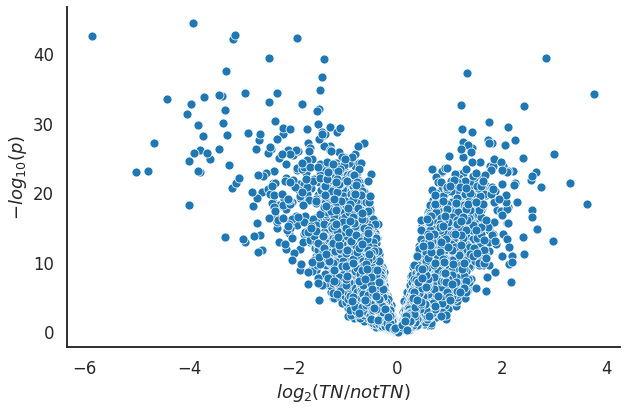

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")
ax = sns.relplot(data=pvalues,x="log_FC",y="-log_p",aspect=1.5,height=6)
ax.set(xlabel="$log_2(TN/not TN)$", ylabel="$-log_{10}(p)$");

The regular interpretation of a Volcano plot is that the ges in the top left and the top right corner are the most interesting ones, as the have a large fold change between the conditions as well as being very significant.